<a href="https://colab.research.google.com/github/daemonX10/Generative-Deep-Learning/blob/main/vae_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import matplotlib.pyplot as plt


def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics
)

from scipy.stats import norm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500

In [ ]:

# Load the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:

def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

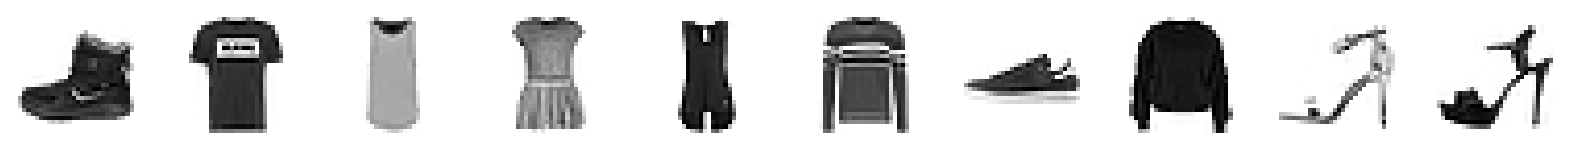

In [ ]:
display(x_train)

In [ ]:
class Sampling(layers.Layer):
    def call(self,inputs):
        z_mean , z_log_var =inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch,dim))
        return z_mean + tf.exp(0.5*z_log_var)*epsilon


In [ ]:
encoder_input = layers.Input(
    shape=(IMAGE_SIZE,IMAGE_SIZE,1),name='encoder_input'
)
x=layers.Conv2D(32,(3,3),strides=2,activation='relu',padding='same')(encoder_input)
x=layers.Conv2D(64,(3,3),strides=2,activation='relu',padding='same')(x)
x=layers.Conv2D(128,(3,3),strides=2,activation='relu',padding='same')(x)
shape_before_flattening = K.int_shape(x)[1:]
x=layers.Flatten()(x)
z_mean = layers.Dense(EMBEDDING_DIM,name='z_mean')(x)
z_log_var = layers.Dense(EMBEDDING_DIM,name='z_log_var')(x)
z = Sampling()([z_mean,z_log_var])

encoder = models.Model(encoder_input,[z_mean,z_log_var,z],name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 2048)      │          0 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
decoder_input = layers.Input(shape=(EMBEDDING_DIM,),name='decoder_input')
x=layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x=layers.Reshape(shape_before_flattening)(x)
x=layers.Conv2DTranspose(
    128,(3,3),strides=2 , activation='relu',padding='same'
)(x)
x = layers.Conv2DTranspose(64,(3,3),strides=2,activation='relu',padding='same')(x)
x=layers.Conv2DTranspose(
    32,(3,3),strides=2,activation='relu',padding='same'
)(x)

decoder_output = layers.Conv2D(
    1,
    (3,3),
    strides=1,
    activation='sigmoid',
    padding='same',
    name='decoder_output',
)(x)

decoder = models.Model(decoder_input,decoder_output)
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class VAE(models.Model):
    def __init__(self,encoder,decoder,**kwargs):
        super(VAE,self).__init__(**kwargs)
        self.encoder= encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = metrics.Mean(
            name='reconstruction_loss'
        )
        self.kl_loss_tracker = metrics.Mean(name='kl_loss')

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
        ]
    def call(self,inputs):
        z_mean , z_log_var , z=encoder(inputs)
        reconstruction = decoder(z)
        return z_mean,z_log_var,reconstruction

    def train_step(self,data):
        with tf.GradientTape() as tape:
            z_mean,z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(BETA*losses.binary_crossentropy(data,reconstruction,axis=(1,2,3)))
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),axis=1
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss,self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads,self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name:m.result() for m in self.metrics}

    def test_step(self,data):
        if isinstance(data,tuple):
            data = data[0]

        z_mean,z_log_var , reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA * losses.binary_crossentropy(data, reconstruction,axis=(1,2,3)))
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5*(1+ z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),axis=1,)
            )
        total_loss = reconstruction_loss + kl

        return {

            "loss":total_loss,
            'reconstruction_loss':reconstruction_loss,
            'kl_loss':kl_loss
        }

In [ ]:
vae = VAE(encoder,decoder)

In [ ]:
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)